# Project_3: Linear Regressions
## Author: Wing Yan Sang
## Date: 11/5/2017

<p><a name="sections"></a></p>


## Sections

- <a href="#split">Split Data</a><br>
- <a href="#preprocessing">Preprocessing</a><br>
 - <a href="#saleprice">Sale Price Log Transformation</a><br>
 - <a href="#imputation">Imputation</a><br>

 - <a href="#scaling">Scaling Select Features</a><br>
 - <a href="#YearBuilt">Group YearBuilt Feature</a><br> 
 - <a href="#subset">Subsetting the 20 Select Features</a><br>
 - <a href="#dummify1">Dummify Categorical Variables</a><br>

- <a href="#ordinals">EDA of ordinals/numeric</a><br>
- <a href="#linear1">Linear Regression 1</a><br>
 - <a href="#residuals_lin1">Residuals/Influence Analysis</a><br>
 - <a href="#kaggle_1">Kaggle Submission</a><br>
- <a href="#categorical">EDA of Categoricals</a><br>
- <a href="#categorica_engineering">Features Engineering of Select Categoricals</a><br>
- <a href="#linear2">Linear Regression 2</a><br>
- <a href="#VIF1">VIF Analysis of Linear Regression 2 Model</a><br>
- <a href="#linear3">Linear Regression 3: All 20 Variables</a><br>
 - <a href="#VIF2">VIF of All 20 Variables</a><br>
 - <a href="#run_linear3">Run Regression</a><br>
 - <a href="#residuals_lin3">Residuals/Influence Analysis</a><br>
 - <a href="#kaggle_3">Kaggle Submission</a><br>
- <a href="#ridge">Ridge Regression</a><br>
 - <a href="#significance_ridge">Signficance Test</a><br>
 - <a href="#residuals_ridge">Residuals/Influence Analysis</a><br>
 - <a href="#impVar_ridge">Important Variables Analysis</a><br>
- <a href="#lasso">Lasso Regression</a><br> 
 - <a href="#significance_lasso">Signficance Test</a><br>
 - <a href="#residuals_lasso">Residuals/Influence Analysis</a><br>
 - <a href="#impVar_lasso">Important Variables Analysis</a><br>

In [129]:
#### Loading the packages to be used
from __future__ import print_function 
import pandas as pd
import numpy as np
from scipy import stats

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge, Lasso, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
from  statsmodels.genmod import generalized_linear_model

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns

<p><a name="split"></a></p>

## Split Dataset into Training and Test

In [130]:

pd.set_option('display.max_columns', 100)

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [131]:
# Save the 'Id' column
train_ID = train_df['Id']
test_ID = test_df['Id']

# Now drop the 'Id' colum since we can not use it as a feature to train our model.
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

In [132]:
y= train_df['SalePrice']
X_TRAIN = train_df.drop('SalePrice', axis=1)
X_TEST = test_df.copy()

- Delete the dataframes that you do not need anymore to save memory.

In [133]:
del train_df, test_df
print(X_TRAIN.shape)
print(X_TEST.shape)

(1460, 79)
(1459, 79)


- Combine training and test datasets before feature engineering.

<p><a name="preprocessing"></a></p>
## Preprocess Training and Test Sets

<p><a name="saleprice"></a></p>
### Sale Price: Log Transform

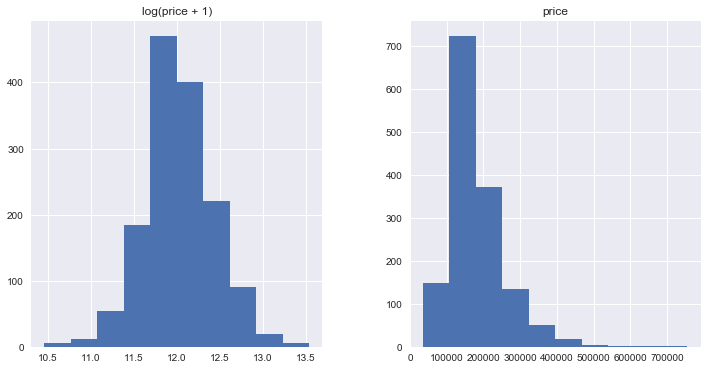

In [134]:
#Inspect distribution of sales prices. Seems that log transformation can make the sales price more "normal".
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":y, "log(price + 1)":np.log1p(y)})
prices.hist()

#log transform the target:
y = np.log1p(y)

<p><a name="imputation"></a></p>
### Imputation

In [135]:
# Idea borrowed from this script: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard


def impute(all_data):

	# PoolQC : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.
	all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

	# MiscFeature : data description says NA means "no misc feature"
	all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

	# Alley : data description says NA means "no alley access"
	all_data["Alley"] = all_data["Alley"].fillna("None")

	# Fence : data description says NA means "no fence"
	all_data["Fence"] = all_data["Fence"].fillna("None")

	# FireplaceQu : data description says NA means "no fireplace"
	all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

	# LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
	# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
	all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

	# GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
	for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
		all_data[col] = all_data[col].fillna('None')

	# GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)
	for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
		all_data[col] = all_data[col].fillna(0)

	# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement
	for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
		all_data[col] = all_data[col].fillna(0)

	# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.
	for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
		all_data[col] = all_data[col].fillna('None')

	# MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
	all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
	all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

	# MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'
	all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

	# Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
	all_data = all_data.drop(['Utilities'], axis=1)

	# Functional : data description says NA means typical
	all_data["Functional"] = all_data["Functional"].fillna("Typ")

	# Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
	all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

	# KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
	all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

	# Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
	all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
	all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

	# SaleType : Fill in again with most frequent which is "WD"
	all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

	# MSSubClass : Na most likely means No building class. We can replace missing values with None
	all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
	
	# Adding total sqfootage feature 
	all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

	# Transforming some numerical variables that are really categorical

	#MSSubClass=The building class
	all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

	#Changing OverallCond into a categorical variable
	all_data['OverallCond'] = all_data['OverallCond'].astype(str)

	#Year and month sold are transformed into categorical features.
	all_data['YrSold'] = all_data['YrSold'].astype(str)
	all_data['MoSold'] = all_data['MoSold'].astype(str)

	return all_data


In [ ]:
impute(all_data)
impute(X_TRAIN)
impute(X_TEST)

<p><a name="scaling"></a></p>
### Scaling Select Variables
Scaling the numeric variables among the selected 20 variables.

In [ ]:
#Plot histograms of numeric variables
columns_num =['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea']
for col in columns_num: 
    plt.figure(figsize=(8, 10)) 
    plt.hist(X_TRAIN[col], bins = 20, normed=1, facecolor='green', alpha=0.5)
    plt.title(col) 
    plt.show()
    


In [138]:
#Scale numeric variables using normal distribution

C =X_TRAIN.copy()
D =X_TEST.copy()
scaler = preprocessing.StandardScaler()

columns_num =['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea']
scaled_df =pd.DataFrame()
for col in columns_num: 
    C[col] = scaler.fit_transform(X_TRAIN[col].values.reshape(-1,1))
    D[col] = scaler.transform(X_TEST[col].values.reshape(-1,1))


/Users/wingyansang/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [139]:
#Setting training and test sets equal to the scaled data frames (C and D)
X_TRAIN = C
X_TEST = D


In [140]:
del C
del D

<p><a name="YearBuilt"></a></p>
### Group YearBuilt Feature into Categories

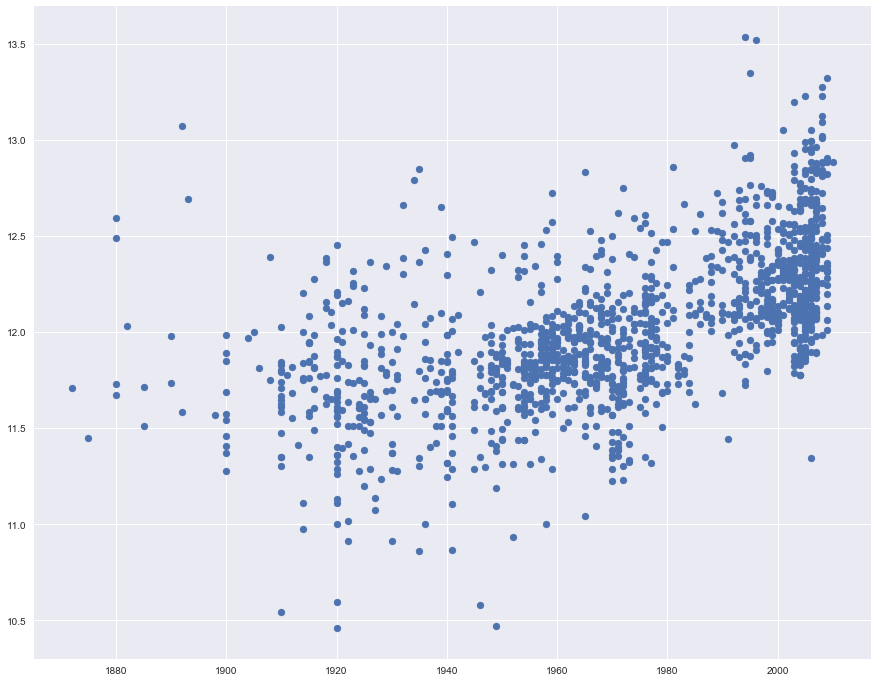

In [141]:
#Plot YrBuilt against SalePrice
fig = plt.figure(figsize=(15, 12))
plt.scatter(X_TRAIN['YearBuilt'], y)
plt.show()

In [142]:
#Change YearBuilt column into 6 groups

def yrBuilt(c):
    if c['YearBuilt'] <=1900:
        return 'to1900'
    elif c['YearBuilt'] <=1920:
        return 'to1920'
    elif c['YearBuilt'] <=1945:
        return 'to1945'
    elif c['YearBuilt'] <=1965:
        return 'to1965'
    elif c['YearBuilt'] <=1980:
        return 'to1980'
    elif c['YearBuilt'] <=2000:
        return 'to2000'
    else:
        return 'toPresent'
    
X_TRAIN['YearBuilt'] = X_TRAIN.apply(yrBuilt, axis=1)


In [143]:
X_TEST['YearBuilt'] = X_TEST.apply(yrBuilt, axis=1)

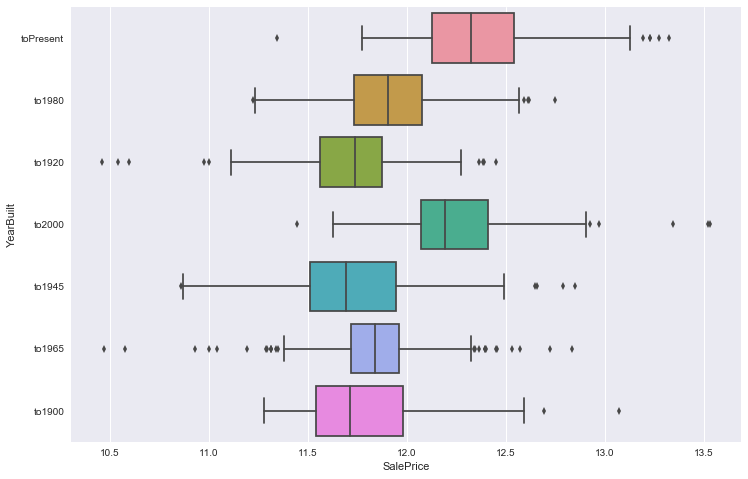

In [144]:
fig = plt.figure(figsize=(12, 8))
sns.boxplot(y, X_TRAIN['YearBuilt'])
plt.show()

<p><a name="subset"></a></p>
### Create Subset of 20 Variables Chosen by Team

In [145]:
train_sub = pd.read_csv("train_sub.csv")
train_sub.rename(columns = {'X1stFlrSF': '1stFlrSF', 'X2ndFlrSF': '2ndFlrSF'}, inplace = True)
train_sub = train_sub.drop("SalePrice", axis = 1)

In [146]:
#train_sub and test_sub are the scaled and imputed data frames of just the 20 variables. 
#Used in Linear Regression 2

colSelected = list(train_sub.columns)
train_sub = pd.DataFrame()
test_sub = pd.DataFrame()
for i in colSelected:
    train_sub[i] =X_TRAIN[i]
    test_sub[i] = X_TEST[i]


<p><a name="dummify1"></a></p>
### Dummify Variables
Dummify categorical variables among the top 20

In [147]:
#Dummify non-numeric features. X will be used for the training of all 20 variables. 
#X_test will be used in making predictions for Kaggle submission.

X = pd.get_dummies(train_sub, drop_first=True, dummy_na=False)
X_test = pd.get_dummies(test_sub, drop_first=True, dummy_na=False)

In [148]:
#dummify numerical variables that are actually categorical features: OverallQual, FullBath, GarageCars,
#and TotRmsAbvGrd
A = pd.DataFrame(X[['GarageCars', 'OverallQual', 'FullBath', 'TotRmsAbvGrd']])

In [149]:
cars = pd.get_dummies(A['GarageCars'], prefix='cars', prefix_sep='__')
cars = cars.drop('cars__0', axis=1)
qual = pd.get_dummies(A['OverallQual'], prefix='qual', prefix_sep='__')
qual = qual.drop('qual__1', axis=1)
bath = pd.get_dummies(A['FullBath'], prefix='bath', prefix_sep='__')
bath = bath.drop('bath__1', axis=1)
rooms = pd.get_dummies(A['TotRmsAbvGrd'], prefix='rooms', prefix_sep='__')
rooms = rooms.drop('rooms__2', axis=1)
X = pd.concat([X,cars,qual,bath,rooms], axis = 1)
X = X.drop(['GarageCars', 'OverallQual', 'FullBath', 'TotRmsAbvGrd'],axis = 1)

In [150]:
del A

In [151]:
A = pd.DataFrame(X_test[['GarageCars', 'OverallQual', 'FullBath', 'TotRmsAbvGrd']])

In [152]:
cars = pd.get_dummies(A['GarageCars'], prefix='cars', prefix_sep='__')
cars = cars.drop('cars__1.0', axis=1)
qual = pd.get_dummies(A['OverallQual'], prefix='qual', prefix_sep='__')
qual = qual.drop('qual__1', axis=1)
bath = pd.get_dummies(A['FullBath'], prefix='bath', prefix_sep='__')
bath = bath.drop('bath__1', axis=1)
rooms = pd.get_dummies(A['TotRmsAbvGrd'], prefix='rooms', prefix_sep='__')
rooms = rooms.drop('rooms__3', axis=1)
X_test = pd.concat([X_test,cars,qual,bath,rooms], axis = 1)
X_test = X_test.drop(['GarageCars', 'OverallQual', 'FullBath', 'TotRmsAbvGrd'],axis = 1)

In [153]:
del A

<p><a name="ordinals"></a></p>

## EDA of Numeric/Ordinals Variables

EDA of the following Numeric Variables: "GrLivArea", "FullBath", "TotRmsAbvGrd", "GarageCars", "GarageArea"

In [154]:
#split into numeric and categorical features and observed values
train_df = pd.read_csv('train.csv')
X_num = train_df[["GrLivArea", "1stFlrSF", "2ndFlrSF", "GarageArea"]]
X_cat = pd.concat([train_df["YearBuilt"],train_sub.drop(["GrLivArea", "1stFlrSF", "2ndFlrSF", "GarageArea",
                    "YearBuilt"], axis = 1)], axis = 1)
del train_df


In [155]:
#Inspect the numeric features
X_num.describe()

,GrLivArea,1stFlrSF,2ndFlrSF,GarageArea
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,1515.463699,1162.626712,346.992466,472.980137
std,525.480383,386.587738,436.528436,213.804841
min,334.000000,334.000000,0.000000,0.000000
25%,1129.500000,882.000000,0.000000,334.500000
50%,1464.000000,1087.000000,0.000000,480.000000
75%,1776.750000,1391.250000,728.000000,576.000000
max,5642.000000,4692.000000,2065.000000,1418.000000


/Users/wingyansang/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


0.46899747732296548

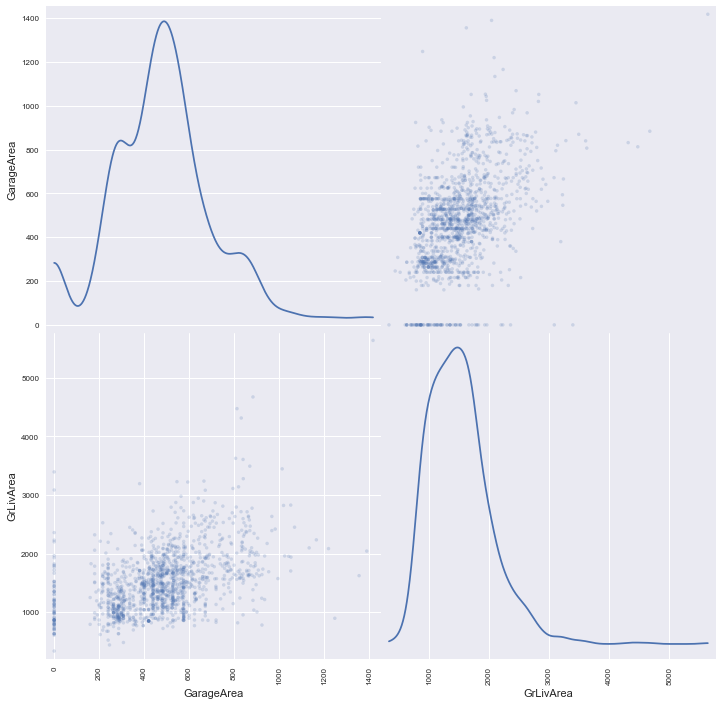

In [156]:
#Check for multicollinearity between GarageArea and GrLivArea. Scatter shows vague linear relationship. 
#Correlation is 0.46899

from pandas.tools.plotting import scatter_matrix
scatter_matrix(X_num[["GarageArea","GrLivArea"]], alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.savefig('num_scatter.png')
np.corrcoef(X_num["GarageArea"], X_num["GrLivArea"])[0, 1]

<p><a name="categorical"></a></p>

## EDA of Categorical Variables

EDA of categorical variables to examine relationship with SalePrice and with each other. 


In [157]:
#View the Categorical Variables
X_cat.head()

,YearBuilt,MSZoning,Neighborhood,HouseStyle,OverallQual,ExterQual,Foundation,BsmtQual,FullBath,TotRmsAbvGrd,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,2003,RL,CollgCr,2Story,7,Gd,PConc,Gd,2,8,RFn,2,TA,TA,Y,WD,Normal
1,1976,RL,Veenker,1Story,6,TA,CBlock,Gd,2,6,RFn,2,TA,TA,Y,WD,Normal
2,2001,RL,CollgCr,2Story,7,Gd,PConc,Gd,2,6,RFn,2,TA,TA,Y,WD,Normal
3,1915,RL,Crawfor,2Story,7,TA,BrkTil,TA,1,7,Unf,3,TA,TA,Y,WD,Abnorml
4,2000,RL,NoRidge,2Story,8,Gd,PConc,Gd,2,9,RFn,3,TA,TA,Y,WD,Normal


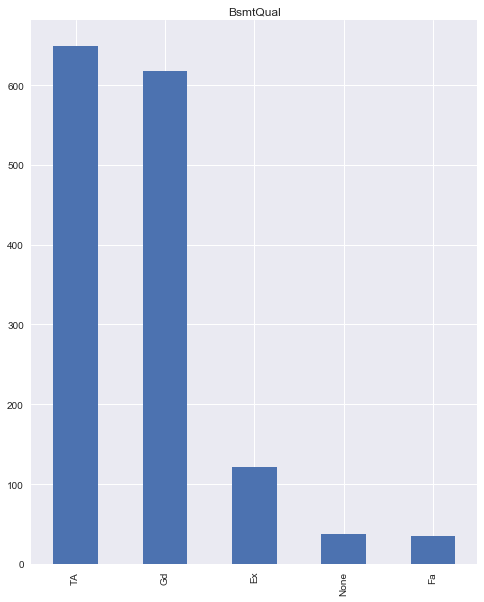

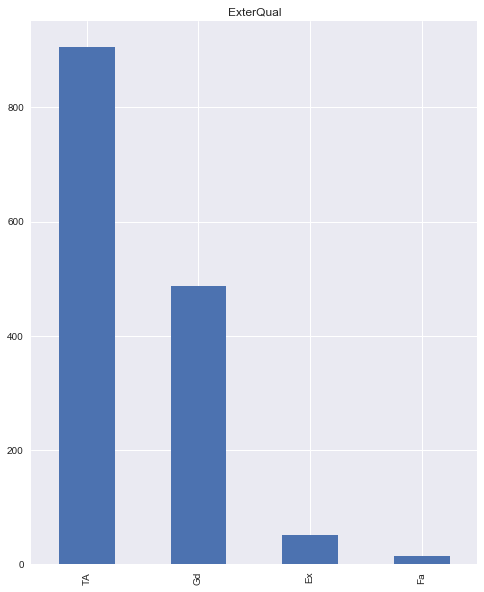

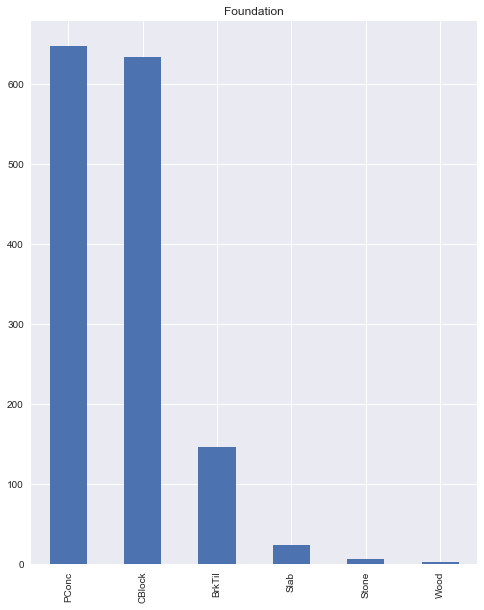

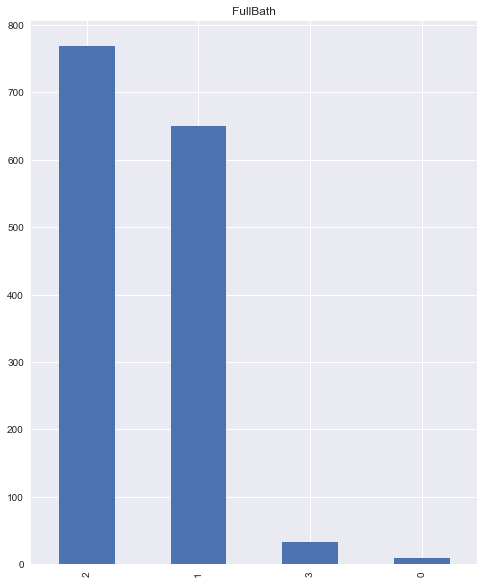

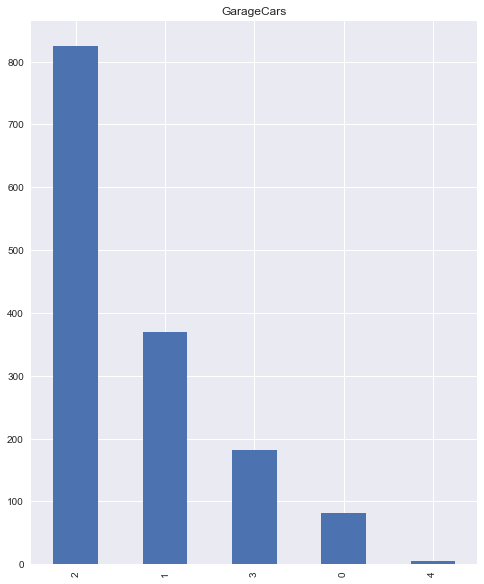

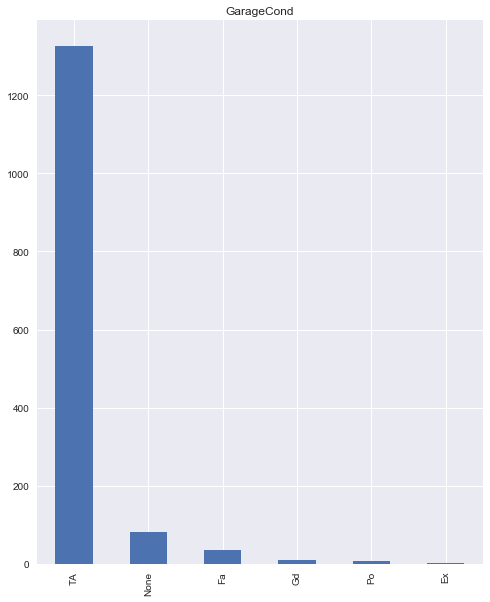

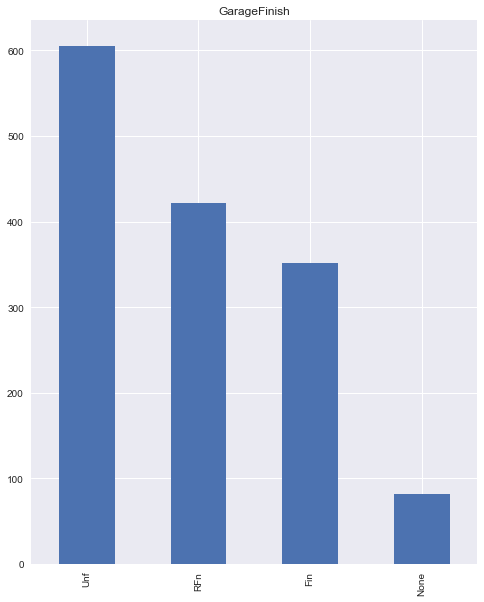

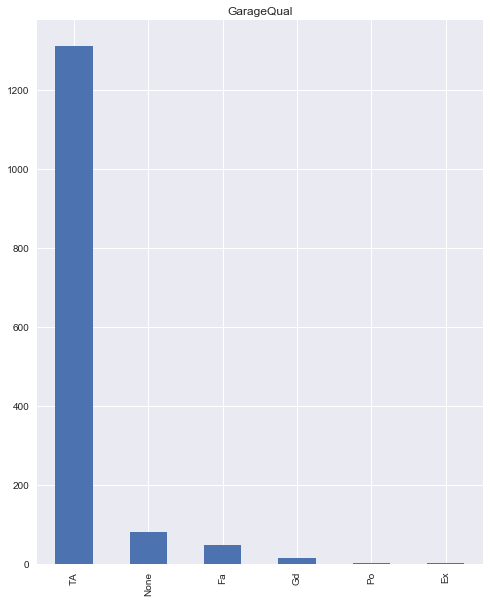

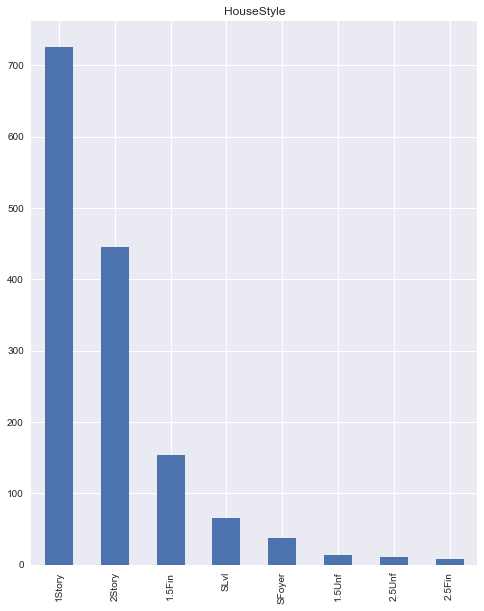

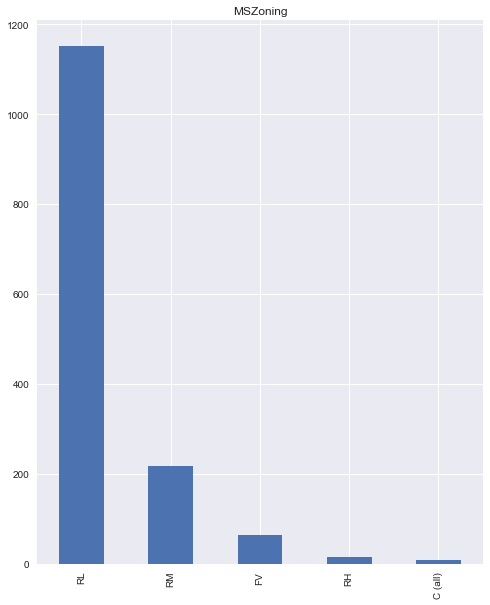

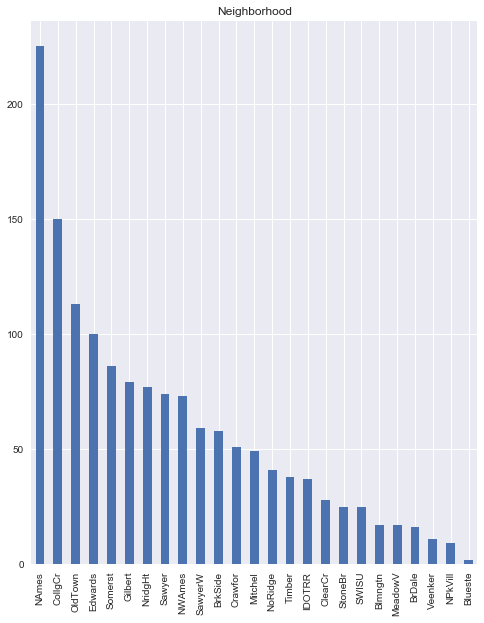

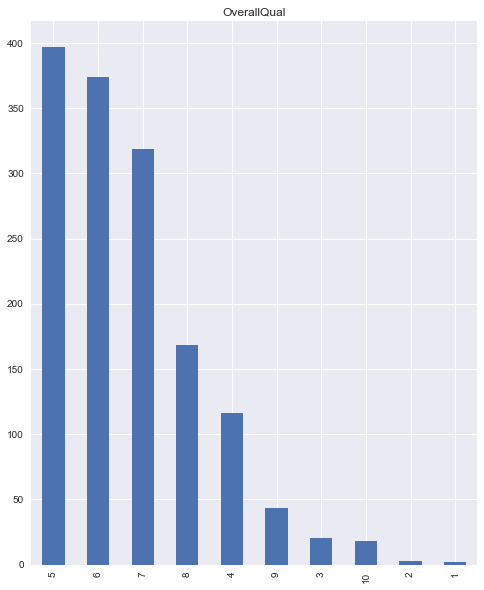

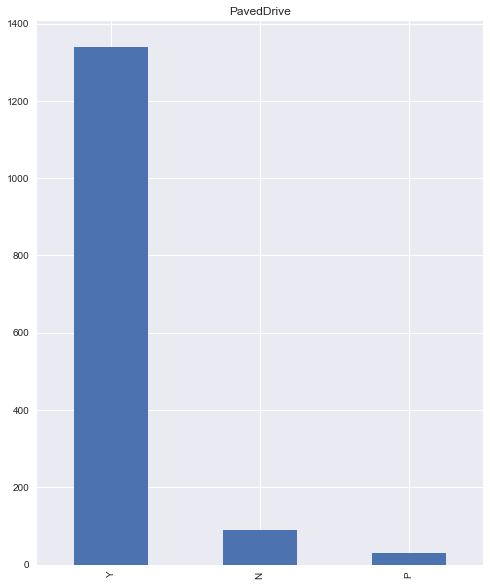

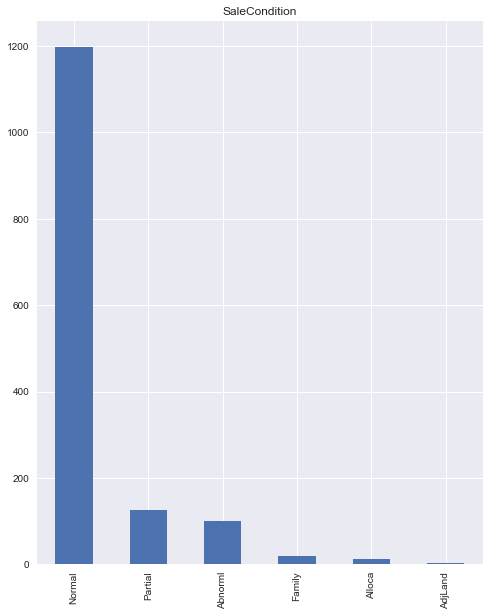

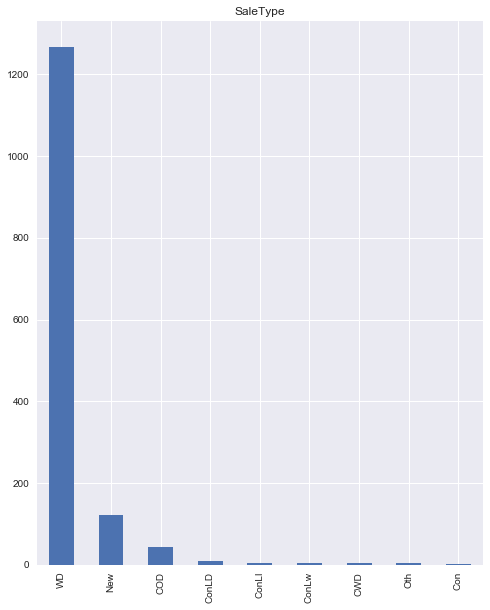

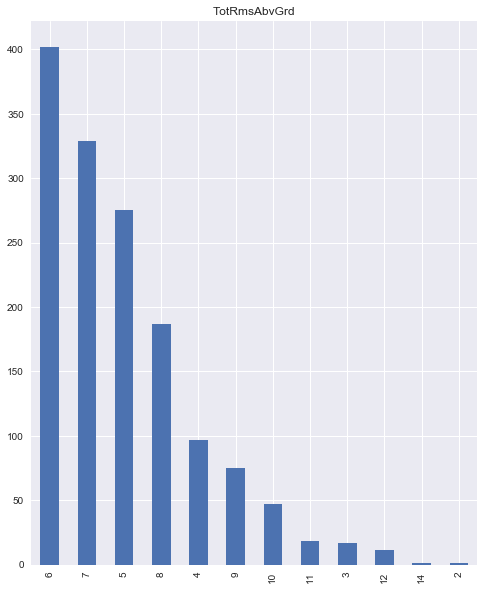

(array([   2.,    4.,    3.,    2.,    3.,    1.,   11.,    4.,   22.,
          26.,   54.,   42.,   26.,   22.,   35.,   23.,   58.,   47.,
         100.,   66.,   95.,   94.,   83.,   46.,   23.,   34.,   82.,
          88.,  206.,  158.]),
 array([ 1872. ,  1876.6,  1881.2,  1885.8,  1890.4,  1895. ,  1899.6,
         1904.2,  1908.8,  1913.4,  1918. ,  1922.6,  1927.2,  1931.8,
         1936.4,  1941. ,  1945.6,  1950.2,  1954.8,  1959.4,  1964. ,
         1968.6,  1973.2,  1977.8,  1982.4,  1987. ,  1991.6,  1996.2,
         2000.8,  2005.4,  2010. ]),
 <a list of 30 Patch objects>)

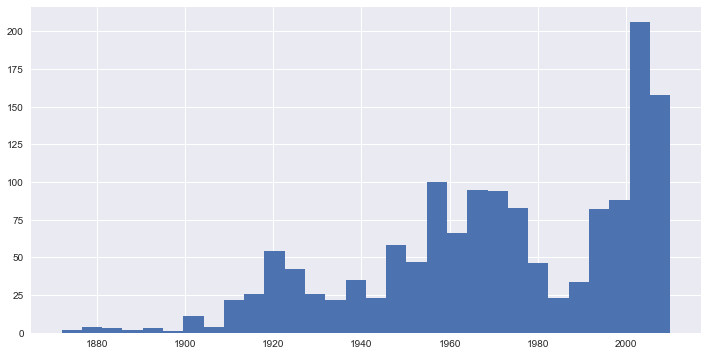

In [158]:
#Bar charts of the categorical variables
#For quality variables, the middle value (typical) dominates, then the second is good.
#GarageFinish is dominated by Unfinished and Rough Finish
#HouseStyle can be broken up into >=2Flr, <=1 1Flr, SplitLevel
#MSZoning dominated by Residential(Low and Medium Density)
#Will need to do further analysis on Neighborhood to see if it values can be combined.
#Sale Type/SaleCondition dominated by Warranty Deed and Normal
#Many homes built after 1990

for idx, col in zip(range(1, len(X_cat.columns)),X_cat.columns.sort_values()): 
    plt.figure(figsize=(8, 10)) 
    X_cat[col].value_counts().plot(kind='bar', )
    plt.title(col) 
    plt.show()
    
plt.hist(X_cat["YearBuilt"], bins=30) 
    


<p><a name="categorical_engineering"></a></p>

## EDA and Features Engineering of Select Categorical Variables

EDA and features engineering of the following categorical variables:
"Neighborhood", "OverallQual", "HouseStyle", "SaleCondition".


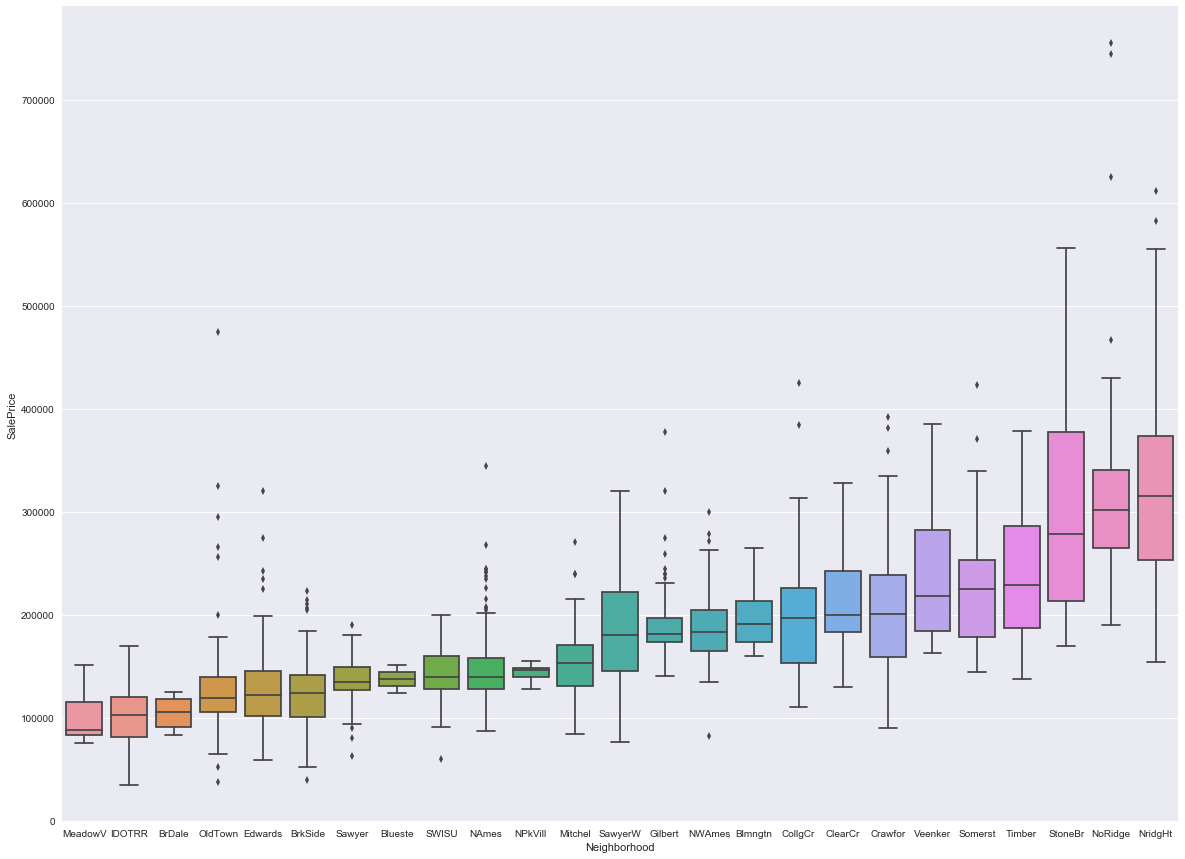

In [159]:
#Boxplot of sales price by neighborhood. 
#Seems like there are big ranges for neighborhoods at the top end of the market whereas ranges are smaller 
#at bottom neighborhoods. Also there are quite a few outliers. May have to remove them to prevent overfitting.
train_df = pd.read_csv('train.csv')
m = train_df.groupby(['Neighborhood'])['SalePrice'].apply(np.median)
m.name = 'MEDIAN'
m = m.sort_values()
m.index


fig = plt.figure(figsize=(20, 15))
sns.boxplot(y=train_df["SalePrice"], x=train_df["Neighborhood"], order = m.index)

In [160]:
#Examine quartile ranges and group them
pd.qcut(m, 4)
x = pd.DataFrame(pd.qcut(m, 4))
x.columns.values[0] = "quartiles"
s = [i for i in range(1,5) for _ in range(6)]
s.insert(0,1)
x["Group"] = s
x.columns.values[1] = "Neigh_Group"
x['Neighborhood'] = x.index.tolist()


In [161]:
#Add Neigh_Group column to train_sub data frame. Count the frequency of each group. 
#Lower value homes most frequent. Higher valued homes least frequent.

new_df = pd.merge(train_sub, x, how='left', on = ["Neighborhood", "Neighborhood"])
new_df = new_df.drop("quartiles",1)
train_sub = new_df
train_sub.groupby("Neigh_Group").size()


Neigh_Group
1    415
2    369
3    398
4    278
dtype: int64

In [162]:
#Group HouseStyle variable by 1stFloor, 2ndFloor, and Split and count frequency. 1Story and 2Story close.

def hstyle(c):
    if c['HouseStyle'] == "1Story":
        return '1Story'
    elif c['HouseStyle'] in ["SFoyer", "SLvl"]:
        return 'Split'
    else:
        return '2Story'

train_sub['House_Group'] = train_sub.apply(hstyle, axis=1)
train_sub.groupby("House_Group").size()

House_Group
1Story    726
2Story    632
Split     102
dtype: int64

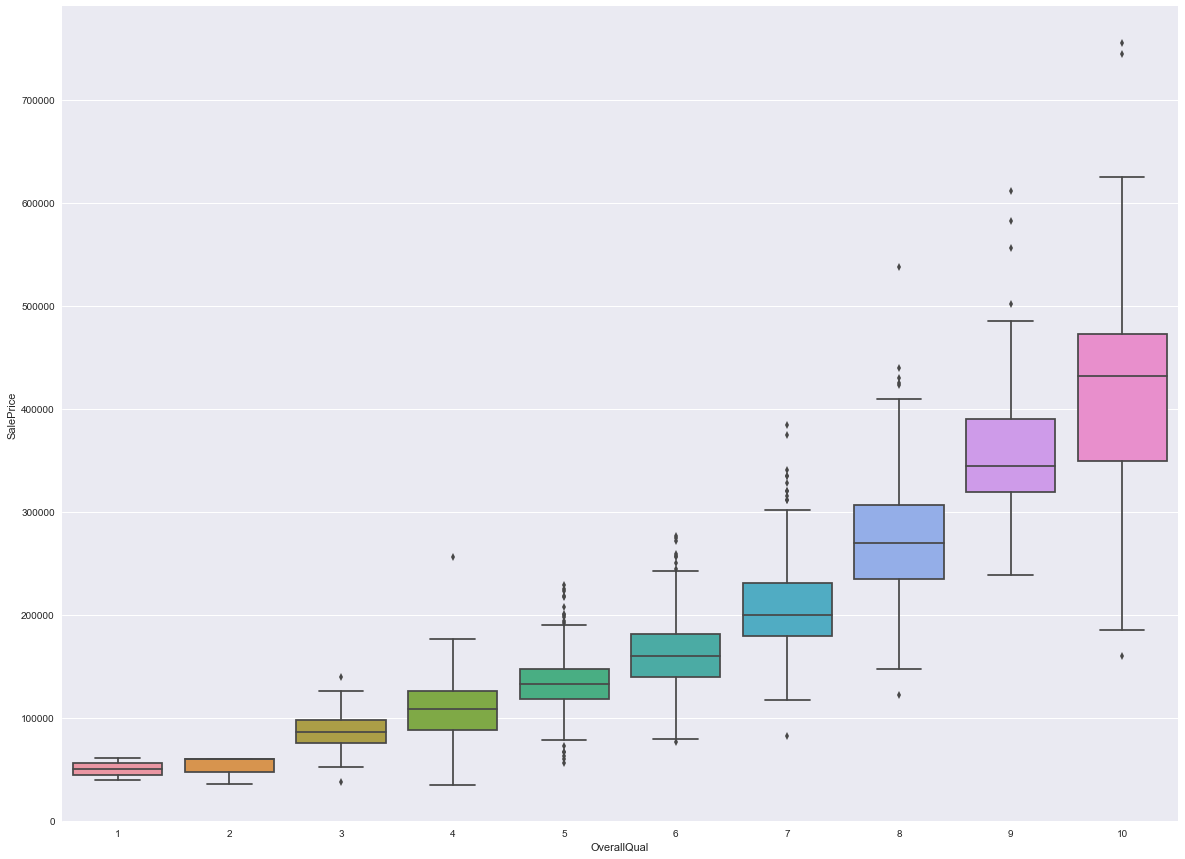

In [163]:
#Boxplot of sales price by OverallQual. As quality goes up, sales price goes up.
#Similar to Neighborhood analysis, there are bigger ranges the higher the quality. 
#Also there are quite a few outliers towards right side of chart.

n = train_df.groupby(['OverallQual'])['SalePrice'].apply(np.median)
n.name = 'MEDIAN'
n = n.sort_values()
n.index


fig = plt.figure(figsize=(20, 15))
sns.boxplot(y=train_df["SalePrice"], x=train_df["OverallQual"], order = n.index)

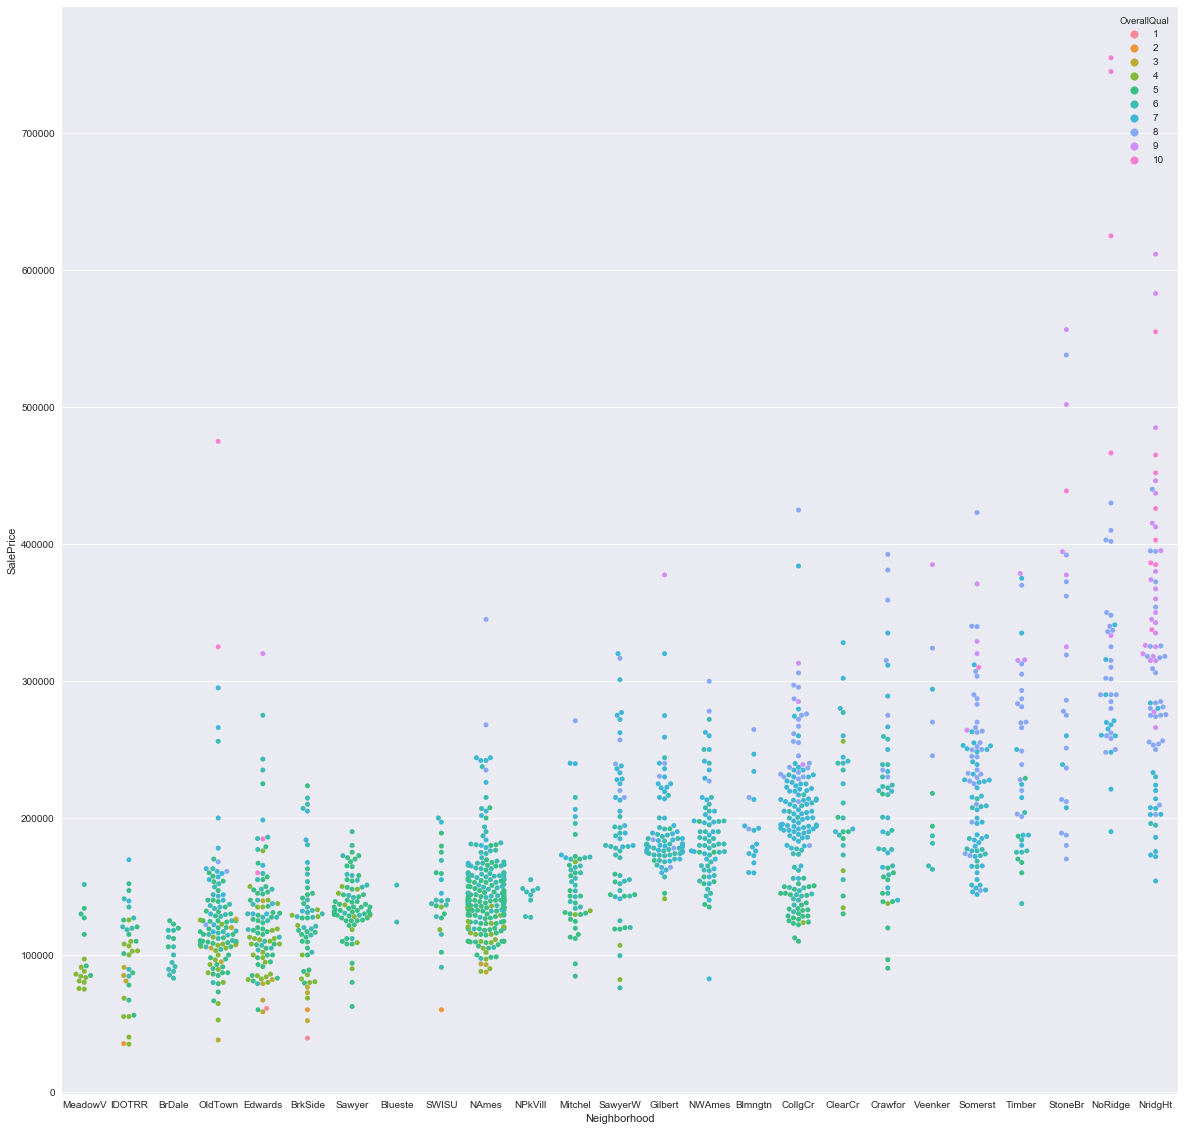

In [164]:
#Examine relationship between Neighborhood, OverallQual, and SalePrice. Lower quality (olive green, green) 
#corresponds to lower price and certain neigborhoods. Same for higher quality homes (violet, pinkish, light blue).

plt.figure(figsize=(20,20))
sns.swarmplot(x = 'Neighborhood', y = 'SalePrice', data=train_df, hue='OverallQual',order = m.index)


In [165]:
#Crosstab also shows some relationship between the Neigh_Group and OverallQual

pd.crosstab(train_sub["Neigh_Group"], train_sub["OverallQual"])


OverallQual,1,2,3,4,5,6,7,8,9,10
Neigh_Group,,,,,,,,,,
1,2,2,17,83,182,94,27,3,1,4
2,0,1,3,27,152,135,42,9,0,0
3,0,0,0,6,56,122,169,41,4,0
4,0,0,0,0,7,23,81,115,38,14


In [166]:
#Examine the quantiles of OverallQual
qual_cut = pd.DataFrame(pd.qcut(n, 3))
qual_cut

,MEDIAN
OverallQual,
1,"(50149.999, 108000.0]"
2,"(50149.999, 108000.0]"
3,"(50149.999, 108000.0]"
4,"(50149.999, 108000.0]"
5,"(108000.0, 200141.0]"
6,"(108000.0, 200141.0]"
7,"(108000.0, 200141.0]"
8,"(200141.0, 432390.0]"
9,"(200141.0, 432390.0]"


In [167]:
#Add column that groups OverallQual into thirds

def overall_qual(c):
    if c['OverallQual'] <= 4:
        return 'Low'
    elif c['OverallQual'] > 7:
        return 'High'
    else:
        return 'Medium'

train_sub['Qual_Group'] = train_sub.apply(overall_qual, axis=1)
train_sub.groupby("Qual_Group").size()

Qual_Group
High       229
Low        141
Medium    1090
dtype: int64

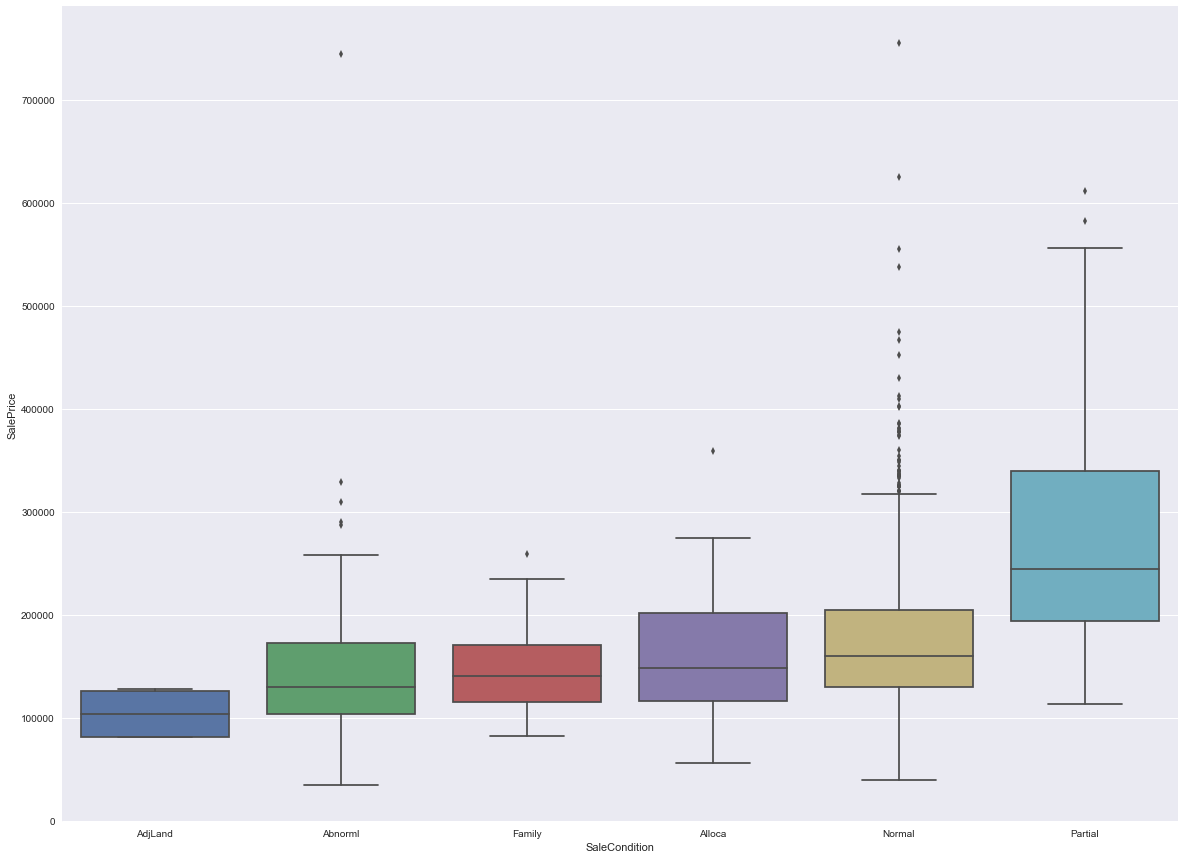

In [168]:
#Boxplot of sales price by SaleCondition. 

n2 = train_df.groupby(['SaleCondition'])['SalePrice'].apply(np.median)
n2.name = 'MEDIAN'
n2 = n2.sort_values()
n2.index


fig = plt.figure(figsize=(20, 15))
sns.boxplot(y=train_df["SalePrice"], x=train_df["SaleCondition"], order = n2.index)

In [169]:
#Examine the quantiles of SaleCondition
pd.qcut(n2, 3)

SaleCondition
AdjLand    (103999.999, 137000.0]
Abnorml    (103999.999, 137000.0]
Family     (137000.0, 152096.667]
Alloca     (137000.0, 152096.667]
Normal     (152096.667, 244600.0]
Partial    (152096.667, 244600.0]
Name: MEDIAN, dtype: category
Categories (3, interval[float64]): [(103999.999, 137000.0] < (137000.0, 152096.667] < (152096.667, 244600.0]]

In [170]:
#Add column that groups SaleCondition into thirds

def saleCond(c):
    if c['SaleCondition'] == "Partial":
        return 'Partial'
    else:
        return 'Non_partial'

train_sub['SaleCond_Group'] = train_sub.apply(saleCond, axis=1)
train_sub.groupby("SaleCond_Group").size()

SaleCond_Group
Non_partial    1335
Partial         125
dtype: int64

In [171]:
#dummify Neigh_Group
df = train_sub.copy()
hood = pd.get_dummies(df['Neigh_Group'], prefix='Neigh', prefix_sep='__')
hood = hood.drop('Neigh__1', axis=1)
hood.head()
df = pd.concat([df.drop('Neigh_Group', axis=1), hood], axis=1)



In [172]:
#dummify HouseStyle
df = df.copy()
style = pd.get_dummies(df['House_Group'], prefix='Style', prefix_sep='__')
style = style.drop('Style__1Story', axis=1)
df = pd.concat([df.drop('House_Group', axis=1), style], axis=1)



In [173]:
#dummify OverallQual
df = df.copy()
qual = pd.get_dummies(df['Qual_Group'], prefix='Qual', prefix_sep='__')
qual = qual.drop('Qual__Low', axis=1)
df = pd.concat([df.drop('Qual_Group', axis=1), qual], axis=1)

In [174]:
#dummify SaleCond
df = df.copy()
saleCond = pd.get_dummies(df['SaleCond_Group'], prefix='saleCond', prefix_sep='__')
saleCond = saleCond.drop('saleCond__Non_partial', axis=1)
df = pd.concat([df.drop('SaleCond_Group', axis=1), saleCond], axis=1)

<p><a name="linear1"></a></p>

## Linear Regression 1

Linear regression using the following variables: "GrLivArea", "Neighborhood", "OverallQual", 
"HouseStyle", "SaleCondition".

In [175]:
#Select five variables to perform linear regression
X5 = pd.concat([df[["GrLivArea"]],df[df.columns[-8:]]], axis = 1)

In [176]:
#Split train_sub into train and test and fit 2nd linear model on train:

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.2, random_state=8)

In [177]:
#Fit 2nd linear model to train set and test against test set
#Results better than first model. R^2 does not change that much between train and test set.

ols = linear_model.LinearRegression()

ols.fit(X_train, y_train)

y_predicted_train = ols.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))

y_predicted_test = ols.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))

print("Root mean squared error for train set: %f" %rms_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))

print("*"*50)

print("Root mean squared error for test set: %f" %rms_test)
print("R^2 for test  set: %f" %ols.score(X_test, y_test))


Root mean squared error for train set: 0.187613
R^2 for train set: 0.784280
**************************************************
Root mean squared error for test set: 0.176133
R^2 for test  set: 0.781409


In [178]:
#Performing same analysis as above using Statsmodel. Based on Cond. No., it seems like multi-collinearity is not
#an issue.
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     467.8
Date:                Wed, 08 Nov 2017   Prob (F-statistic):               0.00
Time:                        14:53:00   Log-Likelihood:                 297.18
No. Observations:                1168   AIC:                            -574.4
Df Residuals:                    1158   BIC:                            -523.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.6543      0.02

In [179]:
#Train on entire dataset
X_all = sm.add_constant(X5)
model_final = sm.OLS(y, X_all)
results = model_final.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     589.6
Date:                Wed, 08 Nov 2017   Prob (F-statistic):               0.00
Time:                        14:53:00   Log-Likelihood:                 392.05
No. Observations:                1460   AIC:                            -764.1
Df Residuals:                    1450   BIC:                            -711.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.6482      0.01

<p><a name="VIF1"></a></p>

## VIF Analysis of Variables in Linear Regression 1

Double-checking to see whether multi-collinearity is an issue.

In [180]:
#Calculate the VIFs (not dependent on model fit). VIFs are below 5.
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_train.drop("const", axis =1).values, i) for 
       i in range(X_train.drop("const", axis =1).shape[1])]
list(zip(vif, X_train.drop("const",axis=1).columns))


[(1.5002033537143242, 'GrLivArea'),
 (1.9809216954889475, 'Neigh__2'),
 (2.1517267372217317, 'Neigh__3'),
 (2.6469943870776698, 'Neigh__4'),
 (2.1908860087616033, 'Style__2Story'),
 (1.1574979232067875, 'Style__Split'),
 (2.5193660320472309, 'Qual__High'),
 (4.6796713111951487, 'Qual__Medium'),
 (1.2452099829940508, 'saleCond__Partial')]

<p><a name="residuals_lin1"></a></p>
### Residuals Analysis of Linear Regression 1
Examine the residuals of the final model fitted in the previous linear regression.

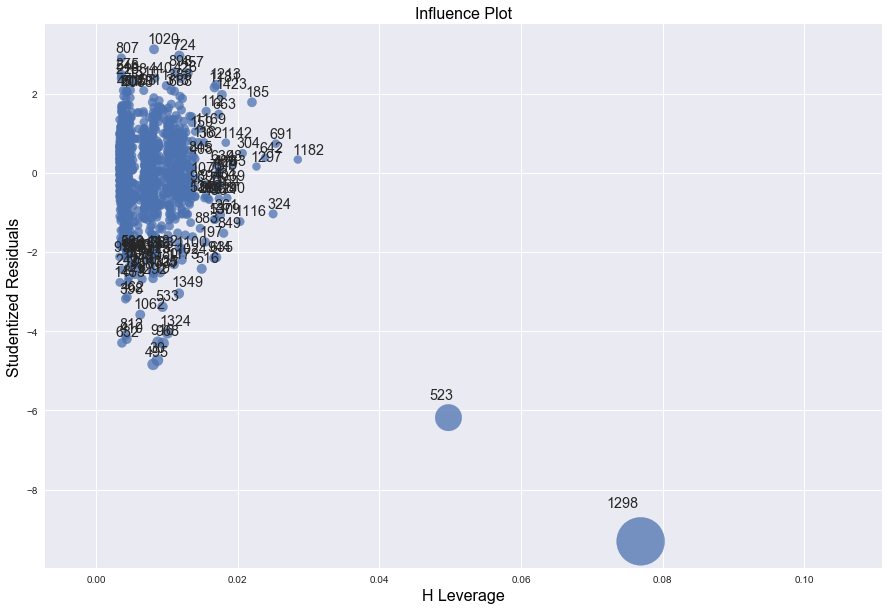

In [181]:
# Examine leverage. 1298 and 523 have huge influence and several outliers in the bottom of chart.
fig, ax = plt.subplots(figsize=(15,10))
fig = sm.graphics.influence_plot(results, ax=ax, criterion="cooks")

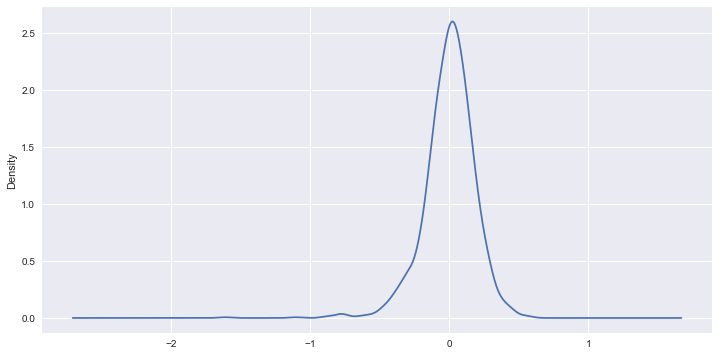

In [128]:
#check for normality. Looks normal.
plt.figure()

results.resid.plot.density()
plt.show()

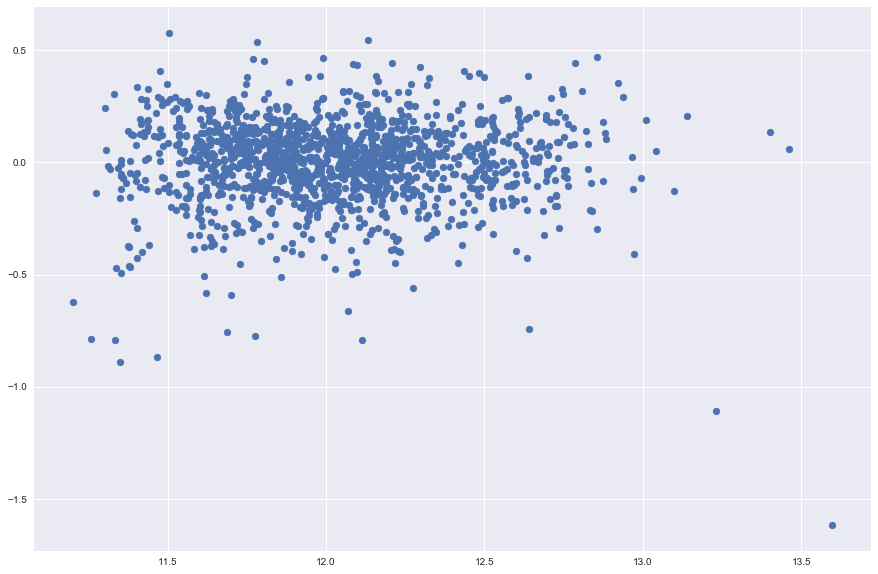

In [182]:
#Plot residuals against fitted values. Residuals seem to vary more as we move from the center.
fig, ax = plt.subplots(figsize=(15,10))
fig = plt.scatter(results.fittedvalues, results.resid)

<p><a name="kaggle_1"></a></p>
### Submission to Kaggle (Linear Regression 1)
    1. Transforming the Test Variables
    2. Make Predictions 
    3. Save Results

In [191]:
set(test_sub["SaleCondition"])

{'Abnorml', 'AdjLand', 'Alloca', 'Family', 'Normal', 'Partial'}

In [188]:
#Group HouseStyle variable by 1stFloor, 2ndFloor, and Split and count frequency. 1Story and 2Story close.

def hstyle(c):
    if c['HouseStyle'] == "1Story":
        return '1Story'
    elif c['HouseStyle'] in ["SFoyer", "SLvl"]:
        return 'Split'
    else:
        return '2Story'

test_sub['House_Group'] = test_sub.apply(hstyle, axis=1)
test_sub.groupby("House_Group").size()

House_Group
1Story    745
2Story    605
Split     109
dtype: int64

In [190]:
#Add column that groups OverallQual into thirds

def overall_qual(c):
    if c['OverallQual'] <= 4:
        return 'Low'
    elif c['OverallQual'] > 7:
        return 'High'
    else:
        return 'Medium'

test_sub['Qual_Group'] = test_sub.apply(overall_qual, axis=1)
test_sub.groupby("Qual_Group").size()

Qual_Group
High       251
Low        142
Medium    1066
dtype: int64

In [192]:
#Add column that groups SaleCondition into thirds

def saleCond(c):
    if c['SaleCondition'] == "Partial":
        return 'Partial'
    else:
        return 'Non_partial'

test_sub['SaleCond_Group'] = test_sub.apply(saleCond, axis=1)
test_sub.groupby("SaleCond_Group").size()

SaleCond_Group
Non_partial    1339
Partial         120
dtype: int64

In [196]:
#join neighborhood key with the test set; x is the data frame containing the key.
new_df = pd.merge(test_sub, x, how='left', on = ["Neighborhood", "Neighborhood"])

In [201]:
test_sub = new_df.drop(["quartiles"], axis = 1)
test_sub.head()

,MSZoning,Neighborhood,HouseStyle,OverallQual,YearBuilt,ExterQual,Foundation,BsmtQual,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,House_Group,Qual_Group,SaleCond_Group,Neigh_Group
0,RH,NAmes,1Story,5,to1965,TA,CBlock,TA,-0.689929,-0.795163,-1.179256,1,5,Unf,1.0,1.202536,TA,TA,Y,WD,Normal,1Story,Medium,Non_partial,2
1,RL,NAmes,1Story,6,to1965,TA,CBlock,TA,0.430511,-0.795163,-0.354966,1,6,Unf,1.0,-0.753188,TA,TA,Y,WD,Normal,1Story,Medium,Non_partial,2
2,RL,Gilbert,2Story,5,to2000,TA,PConc,Gd,-0.607125,0.811239,0.216136,2,6,Fin,2.0,0.042202,TA,TA,Y,WD,Normal,2Story,Medium,Non_partial,3
3,RL,Gilbert,2Story,6,to2000,TA,PConc,TA,-0.612300,0.758532,0.168544,2,7,Fin,2.0,-0.013943,TA,TA,Y,WD,Normal,2Story,Medium,Non_partial,3
4,RL,StoneBr,1Story,8,to2000,Gd,PConc,Gd,0.303718,-0.795163,-0.448246,2,5,RFn,2.0,0.154492,TA,TA,Y,WD,Normal,1Story,High,Non_partial,4


In [202]:
#dummify Neigh_Group
df = test_sub.copy()
hood = pd.get_dummies(df['Neigh_Group'], prefix='Neigh', prefix_sep='__')
hood = hood.drop('Neigh__1', axis=1)
hood.head()
df = pd.concat([df.drop('Neigh_Group', axis=1), hood], axis=1)

In [203]:
#dummify HouseStyle
df = df.copy()
style = pd.get_dummies(df['House_Group'], prefix='Style', prefix_sep='__')
style = style.drop('Style__1Story', axis=1)
df = pd.concat([df.drop('House_Group', axis=1), style], axis=1)

In [204]:
#dummify OverallQual
df = df.copy()
qual = pd.get_dummies(df['Qual_Group'], prefix='Qual', prefix_sep='__')
qual = qual.drop('Qual__Low', axis=1)
df = pd.concat([df.drop('Qual_Group', axis=1), qual], axis=1)

In [205]:
#dummify SaleCond
df = df.copy()
saleCond = pd.get_dummies(df['SaleCond_Group'], prefix='saleCond', prefix_sep='__')
saleCond = saleCond.drop('saleCond__Non_partial', axis=1)
df = pd.concat([df.drop('SaleCond_Group', axis=1), saleCond], axis=1)

In [207]:
#Select five variables to make predictions
X5_test = pd.concat([df[["GrLivArea"]],df[df.columns[-8:]]], axis = 1)

In [229]:
#Make predictions
X5_test = sm.add_constant(X5_test)
y_test = np.exp(results.predict(X5_test))
y_test = pd.DataFrame({'SalePrice': y_test})

In [230]:
submission_1 = pd.concat([test_ID, y_test], axis = 1)

In [231]:
submission_1.head()

,Id,SalePrice
0,1461,128583.254394
1,1462,151398.114199
2,1463,177384.068120
3,1464,175719.110325
4,1465,233918.091377


In [236]:
submission_1.to_csv("submission_1.csv", index=False)

In [238]:
view = pd.read_csv('submission_1.csv')
view.head()

,Id,SalePrice
0,1461,128583.254394
1,1462,151398.114199
2,1463,177384.068120
3,1464,175719.110325
4,1465,233918.091377


<p><a name="eda_cars"></a></p>

## EDA and Feature Engineering of GarageCars

Before substituting GarageCars for GrLivArea, the following EDA analyses were performed to assess its 
relationship with the other variables. GarageCars is then dummified and assessed for its multicollinearity
with the other variables using a VIF analysis.

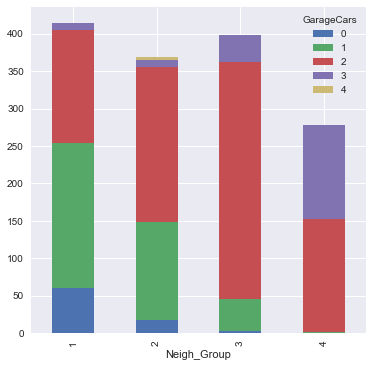

In [345]:
#What if we include GarageCars in the model? Does this improve it? First, let's see what it's correlation is 
#like with the other explanatory variables.

#GarageCars does seem to be correlated with the neighborhood groups.

cars_hood_table = pd.crosstab(index=train_sub["Neigh_Group"], 
                          columns=train_sub["GarageCars"])
cars_hood_table.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

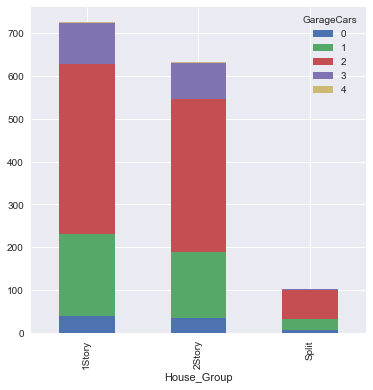

In [346]:
#Not so much with House_Group.
cars_house_table = pd.crosstab(index=train_sub["House_Group"], 
                          columns=train_sub["GarageCars"])
cars_house_table.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

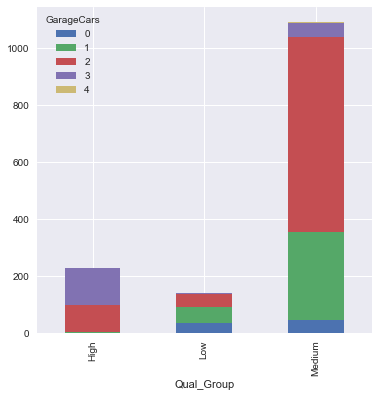

In [347]:
#High quality homes have more garages it seems on average
cars_quality_table = pd.crosstab(index=train_sub["Qual_Group"], 
                          columns=train_sub["GarageCars"])
cars_quality_table.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

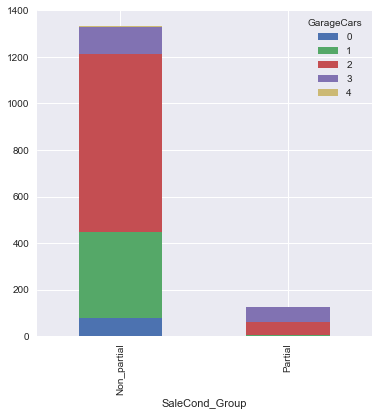

In [348]:
#Inconclusive relationship between GarageCars and SaleCond
cars_salecond_table = pd.crosstab(index=train_sub["SaleCond_Group"], 
                          columns=train_sub["GarageCars"])
cars_salecond_table.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

In [349]:
#Does substituting GarageCars for GrFlrArea reduce RMSE while not creating multicollinearity issues? First,
#let's dummify the variable
df = df.copy()
cars = pd.get_dummies(df['GarageCars'], prefix='Cars', prefix_sep='__')
cars = cars.drop('Cars__0', axis=1)
df = pd.concat([df, cars], axis=1)


In [355]:
#Split train_sub into train and test and fit 2nd linear model on train:

X5 = df[df.columns[-12:]]

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.2, random_state=8)

<p><a name="linear2"></a></p>

## Linear Regression 2

Linear regression using the following variables: "GarageCars", "Neighborhood", "OverallQual", 
"HouseStyle", "SaleCondition".

In [356]:
#2nd Linear Regression. RMSE goes down from 1st model.

ols = linear_model.LinearRegression()

ols.fit(X_train, y_train)

y_predicted_train = ols.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))

y_predicted_test = ols.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))

print("Root mean squared error for train set: %f" %rms_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))

print("*"*50)

print("Root mean squared error for test set: %f" %rms_test)
print("R^2 for test  set: %f" %ols.score(X_test, y_test))


Root mean squared error for train set: 0.216524
R^2 for train set: 0.712673
**************************************************
Root mean squared error for test set: 0.204887
R^2 for test  set: 0.704213


In [358]:
#Checking VIFs. All are below 5.
vif = [variance_inflation_factor(X5.values, i) for 
       i in range(X5.shape[1])]
print("VIF for all the variables:")
list(zip(vif, X5.columns))

VIF for all the variables:


[(0.64688729083019769, 'Neigh__2'),
 (0.92020973762492697, 'Neigh__3'),
 (0.24491788321780528, 'Neigh__4'),
 (0.3625564761910271, 'Style__2Story'),
 (1.1578686507920701, 'Style__Split'),
 (3.9670673524779509, 'Qual__High'),
 (0.53643036798152199, 'Qual__Medium'),
 (1.3402751630642924, 'saleCond__Partial'),
 (0.93189245594883663, 'Cars__1'),
 (0.50256407771056766, 'Cars__2'),
 (3.3585388451606843, 'Cars__3'),
 (1.0292099707404789, 'Cars__4')]

In [359]:
#Performing same analysis as above using Statsmodel. AIC and BIC numbers improve relative to 3rd model and 
#multi-collinearity doesn't seem to be an issue. It appears that we can't reject null that coefficient for
#Style_Split is different from 0.

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     238.7
Date:                Wed, 08 Nov 2017   Prob (F-statistic):          1.65e-302
Time:                        01:05:54   Log-Likelihood:                 129.78
No. Observations:                1168   AIC:                            -233.6
Df Residuals:                    1155   BIC:                            -167.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.2681      0.02

<p><a name="linear3"></a></p>
## Linear Regression 3: Using all 20 Variables (excluding GrLivArea)

<p><a name="VIF2"></a></p>
### Variance Inflation Factor
Calculate the VIF for all the variables using statsmodel.

In [470]:
#Checking VIFs. Many high VIFs
C = X.copy().drop('GrLivArea', axis = 1)
vif = [variance_inflation_factor(C.values, i) for i in range(C.shape[1])]

l = list(zip(vif, C.columns))
l = sorted(l, reverse = True)
l_names = [x[1] for x in l]
l


/Users/wingyansang/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


[(inf, 'qual__9'),
 (inf, 'qual__8'),
 (inf, 'qual__7'),
 (inf, 'qual__6'),
 (inf, 'qual__5'),
 (inf, 'qual__10'),
 (inf, 'cars__4'),
 (inf, 'cars__3'),
 (inf, 'cars__2'),
 (inf, 'cars__1'),
 (inf, 'SaleCondition_Partial'),
 (inf, 'SaleCond_Group_Partial'),
 (inf, 'Qual_Group_Medium'),
 (inf, 'Qual_Group_Low'),
 (inf, 'Neighborhood_Veenker'),
 (inf, 'Neighborhood_Timber'),
 (inf, 'Neighborhood_StoneBr'),
 (inf, 'Neighborhood_Somerst'),
 (inf, 'Neighborhood_SawyerW'),
 (inf, 'Neighborhood_Sawyer'),
 (inf, 'Neighborhood_SWISU'),
 (inf, 'Neighborhood_OldTown'),
 (inf, 'Neighborhood_NridgHt'),
 (inf, 'Neighborhood_NoRidge'),
 (inf, 'Neighborhood_NPkVill'),
 (inf, 'Neighborhood_NAmes'),
 (inf, 'Neighborhood_Mitchel'),
 (inf, 'Neighborhood_MeadowV'),
 (inf, 'Neighborhood_IDOTRR'),
 (inf, 'Neighborhood_Edwards'),
 (inf, 'Neighborhood_BrkSide'),
 (inf, 'Neighborhood_BrDale'),
 (inf, 'Neighborhood_Blueste'),
 (inf, 'Neigh_Group'),
 (inf, 'House_Group_Split'),
 (inf, 'House_Group_2Story'),
 (inf

In [471]:
for i in range(50):
    C = C.drop(l_names[i], axis = 1)
    i = i +1

In [472]:

vif = [variance_inflation_factor(C.values, i) for i in range(C.shape[1])]

l = list(zip(vif, C.columns))
l = sorted(l, reverse = True)
l_names = [x[1] for x in l]
l


[(86.883378308473354, 'MSZoning_RL'),
 (34.07145334088775, 'SaleType_WD'),
 (30.515864694524989, 'ExterQual_TA'),
 (27.295417749060526, 'YearBuilt_toPresent'),
 (24.243503616930731, 'PavedDrive_Y'),
 (19.100572722268641, 'YearBuilt_to1965'),
 (17.227409094960713, 'YearBuilt_to1980'),
 (16.636884375828718, 'YearBuilt_to2000'),
 (16.009309588931803, 'MSZoning_RM'),
 (15.805972596061643, 'BsmtQual_TA'),
 (15.617513348552462, 'SaleCondition_Normal'),
 (14.216491030032515, 'ExterQual_Gd'),
 (12.552522766031041, 'Foundation_PConc'),
 (10.609045969664338, 'Foundation_CBlock'),
 (10.280425003713106, 'BsmtQual_Gd'),
 (8.2783818273533232, 'YearBuilt_to1945'),
 (6.3975320448856072, 'HouseStyle_2Story'),
 (6.3573630947720119, 'MSZoning_FV'),
 (5.3721738015196969, '2ndFlrSF'),
 (5.299620881313011, 'bath__2'),
 (4.8308816059609834, 'SaleType_New'),
 (4.5283361709279131, 'YearBuilt_to1920'),
 (3.9901217024424342, 'BsmtQual_None'),
 (3.9046326297246443, 'GarageFinish_Unf'),
 (3.3140072515000973, 'Foun

In [473]:
for i in range(15):
    C = C.drop(l_names[i], axis = 1)
    i = i +1

In [474]:
vif = [variance_inflation_factor(C.values, i) for i in range(C.shape[1])]

l = list(zip(vif, C.columns))
l = sorted(l, reverse = True)
l_names = [x[1] for x in l]
l


[(4.845600335867922, 'HouseStyle_2Story'),
 (3.8442126812342172, '2ndFlrSF'),
 (3.4166743055258393, 'bath__2'),
 (3.0756983301146077, 'BsmtQual_None'),
 (2.9582621239578351, 'Foundation_Slab'),
 (2.5794419106741158, '1stFlrSF'),
 (2.1667081583080003, 'GarageCond_Po'),
 (2.1117563174538128, 'GarageFinish_Unf'),
 (2.039466365805406, 'GarageQual_Po'),
 (1.8150439146426236, 'GarageFinish_RFn'),
 (1.7969636723910709, 'GarageArea'),
 (1.6486985002752612, 'YearBuilt_to1945'),
 (1.6200465932751691, 'GarageQual_Fa'),
 (1.5184355113735737, 'YearBuilt_to1920'),
 (1.5157367381605669, 'bath__3'),
 (1.4658427549704591, 'GarageCond_Fa'),
 (1.3481286873918084, 'SaleType_New'),
 (1.3395560333771728, 'HouseStyle_2.5Fin'),
 (1.3360536852883498, 'rooms__14'),
 (1.3299664147465489, 'Neighborhood_CollgCr'),
 (1.328327211749085, 'Neighborhood_Gilbert'),
 (1.3067112994781309, 'rooms__10'),
 (1.2965400873617154, 'MSZoning_FV'),
 (1.2942910998094534, 'qual__4'),
 (1.2809312282922714, 'rooms__11'),
 (1.250347121

In [477]:
#Set X equal to the reduced data frame
X52 = C
X52.shape

(1460, 52)

<p><a name="run_linear3"></a></p>
### Linear Regression 3
Fit model with the reduced set of 52 variables

In [478]:
#Split train_sub into train and test and fit 2nd linear model on train:

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X52, y, test_size=0.2, random_state=8)

In [481]:
#Regression result worse than previous one.

ols = linear_model.LinearRegression()

ols.fit(X_train, y_train)

y_predicted_train = ols.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))

y_predicted_test = ols.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))

print("Root mean squared error for train set: %f" %rms_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))

print("*"*50)

print("Root mean squared error for test set: %f" %rms_test)
print("R^2 for test  set: %f" %ols.score(X_test, y_test))


Root mean squared error for train set: 0.186472
R^2 for train set: 0.786895
**************************************************
Root mean squared error for test set: 0.185228
R^2 for test  set: 0.758252


In [482]:
#Performing same analysis as above using Statsmodel. It appears that we can't reject null that coefficients are zero
#for quite a few variables. 

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     79.18
Date:                Wed, 08 Nov 2017   Prob (F-statistic):               0.00
Time:                        01:46:53   Log-Likelihood:                 304.31
No. Observations:                1168   AIC:                            -502.6
Df Residuals:                    1115   BIC:                            -234.3
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    12.08

In [484]:
# fit model to entire dataset

ols = linear_model.LinearRegression()

ols.fit(X52, y)

y_predicted = ols.predict(X52)
mse = mean_squared_error(y, y_predicted)
rms = np.sqrt(mean_squared_error(y, y_predicted))


print("Root mean squared error for entire dataset: %f" %rms)
print("R^2 for entire dataset: %f" %ols.score(X52, y))


Root mean squared error for entire dataset: 0.184529
R^2 for entire dataset: 0.786449


In [485]:
#Doing the same in Statsmodel
X52 = sm.add_constant(X52)
model = sm.OLS(y, X52)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     99.65
Date:                Wed, 08 Nov 2017   Prob (F-statistic):               0.00
Time:                        01:48:21   Log-Likelihood:                 395.68
No. Observations:                1460   AIC:                            -685.4
Df Residuals:                    1407   BIC:                            -405.2
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    12.08

<p><a name="residuals_lin"></a></p>
### Residuals Analysis for Linear Regression 3
Examine the residuals of the final model fitted in the previous linear regression.





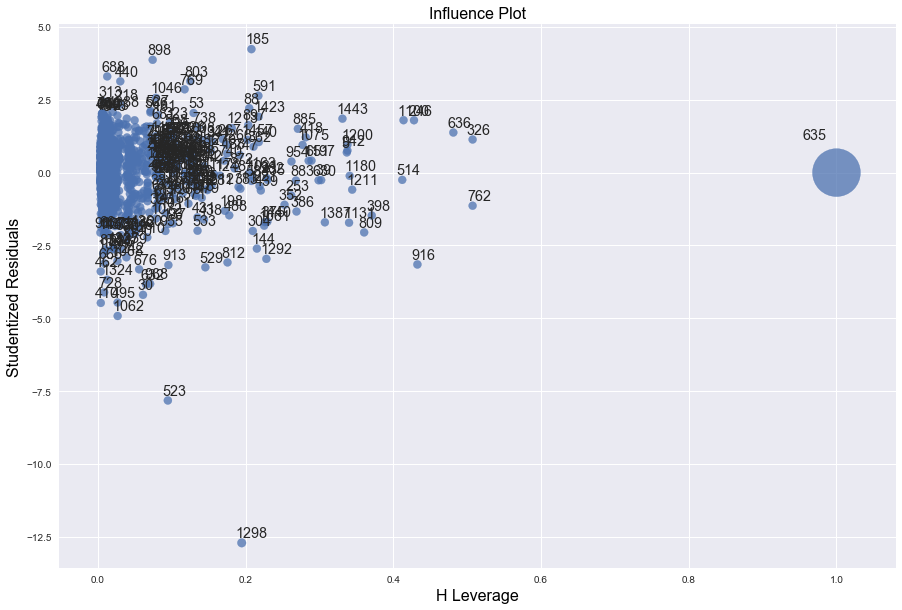

In [486]:
# Examine leverage. 635 has huge influence and several outliers in the bottom of chart.
fig, ax = plt.subplots(figsize=(15,10))
fig = sm.graphics.influence_plot(results, ax=ax, criterion="cooks")

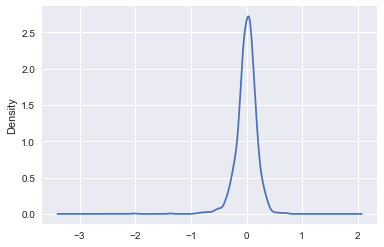

In [487]:
#check for normality. Looks normal.
plt.figure()

results.resid.plot.density()
plt.show()

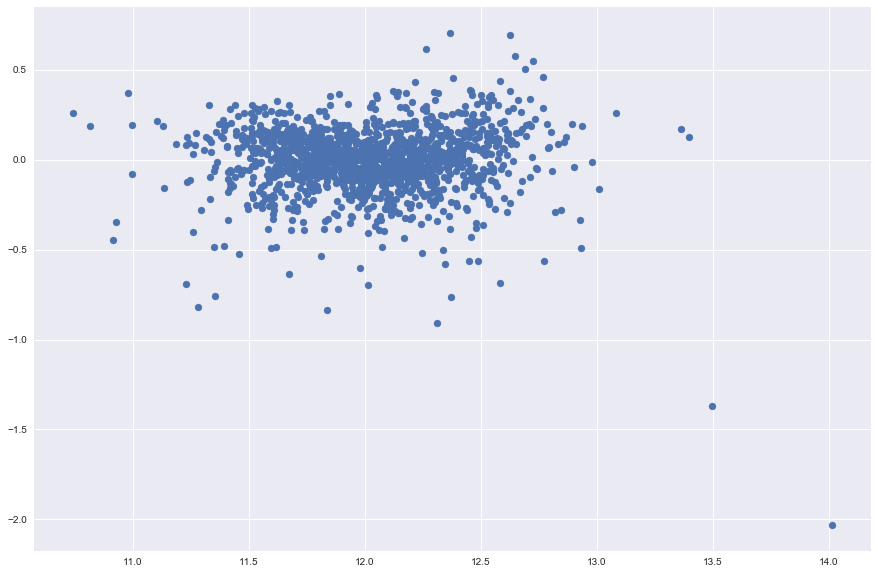

In [489]:
#Plot residuals against fitted values. Residuals seem to vary more as we move from the center.
fig, ax = plt.subplots(figsize=(15,10))
fig = plt.scatter(results.fittedvalues, results.resid)

<p><a name="kaggle_3"></a></p>
### Submission to Kaggle (Linear Regression 3)
    1. Transforming the Test Variables
    2. Make Predictions 
    3. Save Results

In [ ]:
#Transform the test variables to make consistent with regression model



<p><a name="ridge"></a></p>
## Ridge Analysis using all 20 Variables 

In [500]:
# Create training and test sets

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [501]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [502]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

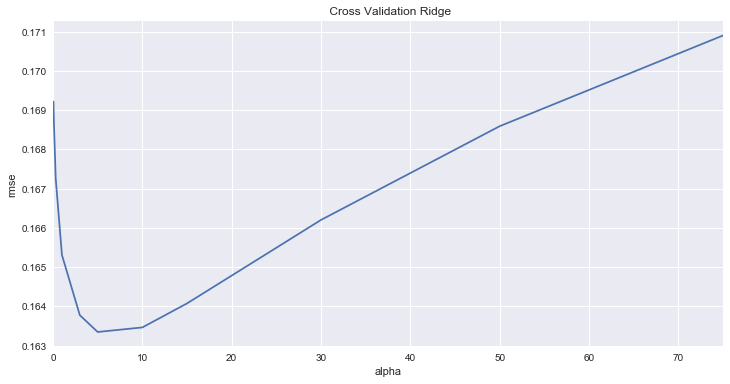

In [503]:
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = " Cross Validation Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [504]:
#Best alpha is 5
print(cv_ridge)
print(cv_ridge.min())

0.05     0.169215
0.10     0.168692
0.30     0.167266
1.00     0.165308
3.00     0.163776
5.00     0.163348
10.00    0.163463
15.00    0.164075
30.00    0.166201
50.00    0.168589
75.00    0.170900
dtype: float64
0.163347540375


In [505]:
#Fitting to entire training subset using alpha = 5
Ridge_best = Ridge(alpha = 5)
Ridge_best.fit(X_train, y_train)
print("Ridge training R-squared is: %f" %Ridge_best.score(X_train, y_train))

y_predicted_train = Ridge_best.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))
print("Ridge training RMSE is: %f" %rms_train)

Ridge training R-squared is: 0.871991
Ridge training RMSE is: 0.144523


In [507]:
#Test model against test set. R^2 and RMSE improved.

y_predicted_test = Ridge_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))
print("Ridge test R-squared is: %f" %Ridge_best.score(X_test, y_test))
print("Ridge test RMSE is: %f" %rms_test)

Ridge test R-squared is: 0.855214
Ridge test RMSE is: 0.143347


In [509]:
#Fitting to entire training set
Ridge_final = Ridge(alpha = 5)
Ridge_final.fit(X, y)
print("Ridge R-squared on entire training set is: %f" %Ridge_best.score(X, y))

y_predicted = Ridge_final.predict(X)
mse = mean_squared_error(y, y_predicted)
rms = np.sqrt(mean_squared_error(y, y_predicted))
print("Ridg RMSE is: %f" %rms)

Ridge R-squared on entire training set is: 0.869431
Ridg RMSE is: 0.142855


In [510]:
Ridge_final.get_params()

{'alpha': 5,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

<p><a name="significance_ridge"></a></p>
### Significance Test of Coefficients

#Are the coefficients significantly different from 0

<p><a name="residuals_ridge"></a></p>
### Residuals and Influence Analysis


In [78]:
#Any assumption violations? 

<p><a name="impVar_ridge"></a></p>
### Important Variables Analysis

In [ ]:
#Which are the important variables?

<p><a name="lasso"></a></p>
## Lasso Analysis Using All 20 Variables


In [531]:
# LassoCV
model_lasso = Lasso()
alphas = np.logspace(-2, 4, 100)
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]

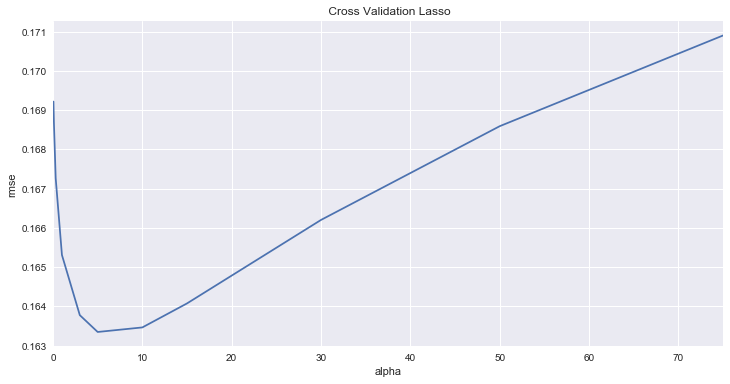

In [532]:
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_ridge.plot(title = " Cross Validation Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [ ]:
#Best alpha is .01. So small.
print(cv_lasso)
print(cv_lasso.min())

In [537]:
#Fitting to entire training subset using alpha = .01
Lasso_best = Lasso(alpha = .01)
Lasso_best.fit(X_train, y_train)
print("Lasso training R-squared is: %f" %Lasso_best.score(X_train, y_train))

y_predicted_train = Lasso_best.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))
print("Lasso training RMSE is: %f" %rms_train)

Lasso training R-squared is: 0.787560
Lasso training RMSE is: 0.186181


In [538]:
#There may be overfitting issues. The metrics improved a bit.
y_predicted_test = Lasso_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))
print("Lasso test R-squared is: %f" %Lasso_best.score(X_test, y_test))
print("Lasso test RMSE is: %f" %rms_test)

Lasso test R-squared is: 0.797153
Lasso test RMSE is: 0.169672


In [539]:
#Fitting to entire training set. Improves again. 
Lasso_final = Ridge(alpha = .01)
Lasso_final.fit(X, y)
print("Lasso R-squared on entire training set is: %f" %Lasso_best.score(X, y))

y_predicted = Lasso_final.predict(X)
mse = mean_squared_error(y, y_predicted)
rms = np.sqrt(mean_squared_error(y, y_predicted))
print("Lasso RMSE is: %f" %rms)

Lasso R-squared on entire training set is: 0.789977
Lasso RMSE is: 0.137362


<p><a name="significance_lasso"></a></p>
### Significance Test of Coefficients

In [ ]:
#Are the coefficients significantly different from 0?

<p><a name="residuals_lasso"></a></p>
### Residuals and Influence Analysis

In [ ]:
#Any assumption violations? 

<p><a name="impVar_lasso"></a></p>
### Important Variables Analysis

In [ ]:
#Which are the important variables